*Short study project in econometrics of exchange rates course.* 

*By BERNARD Arthur and ZAETTA Paul.*



***
***


<h1><center> Statistical and econometric approach in order to compare bitcoin as a crypto-currency to a “classical” currency.</center></h1>


***
***

## Abstract:

From about ten years now the bitcoin has developed greatly in our society and in particular in the financial institutions, for instance with the apparition of future contracts traded on an organized exchange market since the end of 2017. We have daily users on the one hand and speculators on the other. We can affirm that the number of these two types of agents increased very strongly during this decade. Actually, this craze led to at an amount of approximately 500 billion dollars concerning the market capitalization of the crypto-currencies’ market. It represents, the DGP of Switzerland, a huge and impending amount. Among this capitalization, the bitcoin represents almost the one-third of this total. In that sense, the bitcoin is a recent and very interesting topic. However, this crypto-currency raises many questions about its fluctuations. In fact, one may wonder if its variations are solely related to speculation or is there a rational process underlying. If we consider the bitcoin as a currency such as the euro for example, then, we have to find some similarities between both. Consequently, the aim of this study is to analyze with an econometric and statistical approach the price behavior between the bitcoin and some exchange rates.

***
***

## Inroduction:

In order to develop statistical and econometric issue about the bitcoin and “classical” currencies we have collected data mainly from two sources. The first one is a data base from kaggle where the data provide from “coinbase.com”, bitcoin intraday price and the second one is a personnal source who provide us euro-dollar intraday exchange rate from  “reuters.com”. The intraday data means that we have collect data every minutes over the period from January 2015 to January 2018. We can consider our sample as a continuous-time process in the sense that the prices changes continuously, even though the price is only observed at discrete time point (interval of one minute). But we prefer to agggregate our data such that we have a five minutes interval. Hence we have approximately 300,000 data by series. We note that in this study, among all crypto-currencies we are focused only on the bitcoin. The simplest reason is that in the past and presently the bitcoin is considered as the reference currency and thus represents all the crypto-currencies.

Our study is decomposed in the following structure; a first part where we analyze the statistical properties of each series in order to stick out of important information from their distributions. In a second part we are focused on the periodicity of volatility over a week and over a day. Finally, in a third part we will try to analyze how negative and positive shocks impact the volatility. This is the main part of our work. In raison that in this study we want to know if the bitcoin activity in terms of trading has similarities with an exchange rate trading activity.

In [111]:
""" Import some libraries and define some econometrics tools

"""
import json 
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
from matplotlib import cm


class temps():
    def __init__(self):
        pass
    
    def TS_to_date(self, TS, form='%Y-%m-%d %H:%M:%S'):
        return time.strftime(form, time.localtime(TS))

    def date_to_TS(self, date, form='%Y-%m-%d %H:%M:%S'):
        return time.mktime(time.strptime(date, form))
    

class EconometricTools():
    """ Series must be in columns and it's preferable that series 
    are numpy.array
    
    """
    def __init__(self):
        pass
        
    
    def parzen_rosenblatt_estimator(self, grid, series):
        """ Estimation of density.
        
        """
        N = len(series)
        n = len(grid)
        h_s = 1.06 * np.std(series) * N ** (-0.2)
        fX = np.zeros((n,1))
        for i in range(n):
            fX[i] = np.sum(self.kernel_normal((series - grid[i]) / h_s))
        fX = fX / (N * h_s)
        return fX
        
    
    def kernel_normal(self, series, m=0, s=1):
        """ Normal kernel.
        
        """
        if m == 0 and s == 1:
            return np.exp((-1 / 2) * (series) ** 2) / (np.sqrt(2 * np.pi))
        else:
            return np.exp((-1 / 2) * ((series - m) / s) ** 2) / (s * np.sqrt(2 * np.pi))
        
    
    def auto_cov_emp_vect(self, series, length=50):
        """ Provide a vector of the autocorrelation.
        
        """
        T = len(series)
        gama_k = np.zeros(length)
        for k in range(length):
            gama_k[k] = np.mean(np.multiply(series[k + 1:T],series[1:T - k])) - np.mean(series[k + 1:T]) * np.mean(series[1:T - k])
        return gama_k
        
    
    def ols_est(self, series_X, series_Y):
        """ Provide the coefficients estimate of a simple linear regression
        
        """
        if np.ndim(series_X) == 1:
            return ((series_X@ series_X) ** -1) * series_X@ series_Y
        else:
            xx = np.linalg.inv(np.transpose(series_X)@ series_X)
            xy = np.transpose(series_X)@ series_Y
            return xx@ xy
        
    

In [112]:
""" Import and clean data EURUSD:

"""
path = 'D:/Users/Arthur/Documents/M2_AMSE/Econometrie_des_Taux_de_Changes/EURUSD_1min_'

raw_2015 = pd.read_csv(
    path+'2015.csv', 
    sep = ';', 
    header = None, 
    usecols = [0, 1]
).rename(columns = {0 : 'Date', 1 : 'Close'})

raw_2016 = pd.read_csv(
    path+'2016.csv', 
    sep = ';', 
    header = None, 
    usecols = [0, 1]
).rename(columns = {0 : 'Date', 1 : 'Close'})

raw_2017 = pd.read_csv(
    path+'2017.csv', 
    sep = ';', 
    header = None, 
    usecols = [0, 1]
).rename(columns = {0: 'Date', 1: 'Close'})

raw = [raw_2015, raw_2016, raw_2017]
clean = pd.DataFrame()
for elt in raw:
    elt.Date = pd.to_datetime(elt.Date)
    elt.Date = (elt.Date.apply(lambda x: x.timestamp()+28800)
                .astype(int)) # Convert to GMT time
    elt.Close = elt.Close.apply(lambda x: float(x.replace(',', '.')))
    elt = elt[elt.Date % 300 == 0]
    clean_one = elt
    start = elt.Date.iloc[0]
    end = elt.Date.iloc[-1]
    nb = round((end - start) / 300 + 1)
    clean_one = pd.Series(range(0, int(nb)), name='Date') * 300 + start
    clean_one = pd.DataFrame(clean_one).merge(elt, on='Date', how='outer')
    clean = pd.concat([clean, clean_one], axis=0)

clean = clean.fillna(method='pad').reset_index(drop=True)

lr = np.log(clean.Close).diff(periods=1).rename('lr')
ret = clean.Close.diff(periods=1).rename('ret')

clean = pd.concat(
    [clean, lr, ret], 
    axis = 1
).rename(columns = {
        'Date' : 'TS', 
        'Close' : 'close'
    }).drop(0, axis=0).reset_index(drop=True)

clean = clean.assign(
    abs_lr = abs(clean.lr), 
    log_price = np.log(clean.close), 
    date = pd.to_datetime(clean.TS, unit='s'), 
    weekday = pd.to_datetime(clean.TS, unit='s').dt.weekday_name, 
    time = pd.to_datetime(clean.TS, unit='s').dt.time, 
    day = pd.to_datetime(clean.TS, unit='s').dt.date
)

df_eurusd = clean

In [114]:
""" Import and clean data BTCUSD:

"""
path = 'D:/Users/Arthur/Documents/M2_AMSE/Econometrie_des_Taux_de_Changes/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv'
raw = pd.read_csv(path)

raw = raw.drop([
        'Open', 
        'High', 
        'Low', 
        'Volume_(BTC)', 
        'Volume_(Currency)', 
        'Weighted_Price'
    ], axis=1)

raw = raw.assign(log_price=np.log(raw.Close))
df = raw[raw.Timestamp % 300 == 0]
df = df.reset_index().drop('index', axis=1)

df.Timestamp = df.Timestamp - 3600 # Convert to GMT time
fd = df.diff(periods=1, axis=0)
fd = fd.reset_index()

df = (df.reset_index()
      .merge(fd, on='index')
      .drop(['Timestamp_y', 'index'], axis=1)
      .rename(columns={'Timestamp_x': 'TS', 'Close_x': 'close', 
                       'log_price_x': 'log_price', 
                       'log_price_y': 'lr', 'Close_y': 'ret'})
      .drop(range(5000), axis=0)
      .reset_index(drop=True))
df = df.assign(abs_lr = abs(df.lr), 
               date = pd.to_datetime(df.TS, unit='s'), 
               weekday = pd.to_datetime(df.TS, unit='s').dt.weekday_name, 
               time = pd.to_datetime(df.TS, unit='s').dt.time, 
               day = pd.to_datetime(df.TS, unit='s').dt.date)

df_btcusd = df

***
***

## **I. Descriptive statistics**

An important property about time series is to have stationary series. Consequently, we need to transform our non-stationary series into stationary series. To do that, we transform the exchange rates and the bitcoin price into log returns, we can write this as the following form:

> $𝑟_𝑖$$_,$$_𝑡$ = $𝑙𝑜𝑔(𝑃_𝑖$$_,$$_𝑡$ ⁄ $𝑃_𝑖$$_,$$_𝑡$$_−$$_1$),

where, $𝑟_𝑖$$_,$$_𝑡$ is the return of asset i at date t, $𝑃_𝑖$$_,$$_𝑡$ and $𝑃_𝑖$$_,$$_𝑡$$_−$$_1$ are the closing prices for date t and t-1, respectively.

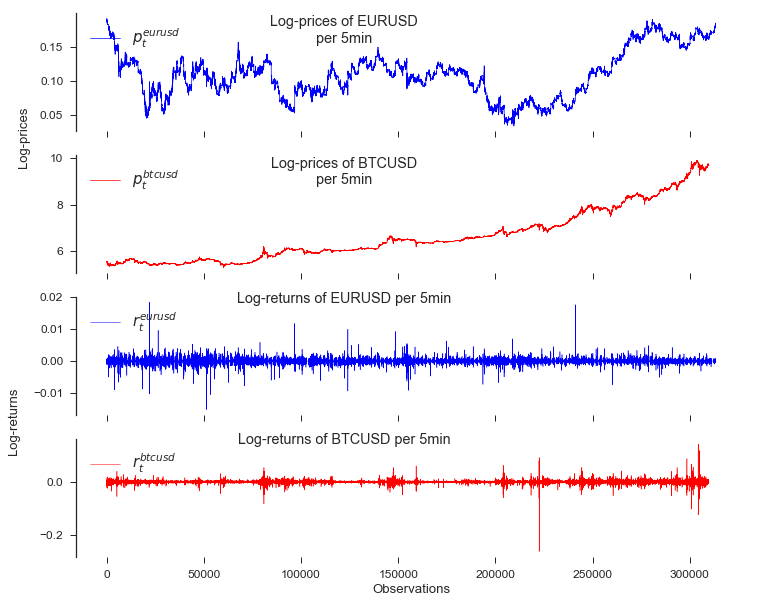

In [71]:
""" Plot log-prices and log-returns of BTCUSD and EURUSD:

"""
sns.set(style="white", context="notebook", font_scale=1.2)
sns.set_style("ticks")

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

ax1.plot(df_eurusd.log_price, 'b-', linewidth=0.7)
ax1.set_title('Log-prices of EURUSD\nper 5min', position=(0.4, 0.7))
ax1.legend([r'$p_t^{eurusd}$'], loc=2, fontsize=15)

ax2.plot(df_btcusd.log_price, 'r-', linewidth=0.7)
ax2.set_title('Log-prices of BTCUSD\nper 5min', position=(0.4, 0.7))
ax2.set_ylabel('Log-prices', y=1.15, labelpad=20)
ax2.legend([r'$p_t^{btcusd}$'], loc=2, fontsize=15)

ax3.plot(df_eurusd.lr, 'b-', linewidth=0.5)
ax3.set_title('Log-returns of EURUSD per 5min', position=(0.4, 0.9))
ax3.legend([r'$r_t^{eurusd}$'], loc=2, fontsize=15)

ax4.plot(df_btcusd.lr, 'r-', linewidth=0.5)
ax4.set_title('Log-returns of BTCUSD per 5min', position=(0.4, 0.9))
ax4.legend([r'$r_t^{btcusd}$'], loc=2, fontsize=15)
ax4.set_ylabel('Log-returns', y=1.15, labelpad=20)
ax4.set_xlabel('Observations')

sns.despine(bottom=True)
plt.show()

***
We can observe below the autocorrelation functions about the exchange rate EUR-USD and the BTC-USD in term of log-returns and absolute log-returns.

On the correlograms we observe the absence of autocorrelation for the log-returns for both EUR-USD and BTC-USD, this can mean the series are stationary. About the autocorrelation function of the absolute value’s returns we distinct two different behaviors. We observe that the euro-dollar autocorrelation is decreasing periodically with some negative autocorrelation coefficient after the 400th lag. Referring to the autocorrelation function bitcoin-dollar, it shows a strong persistence and the autocorrelation coefficients decrease very slowly.

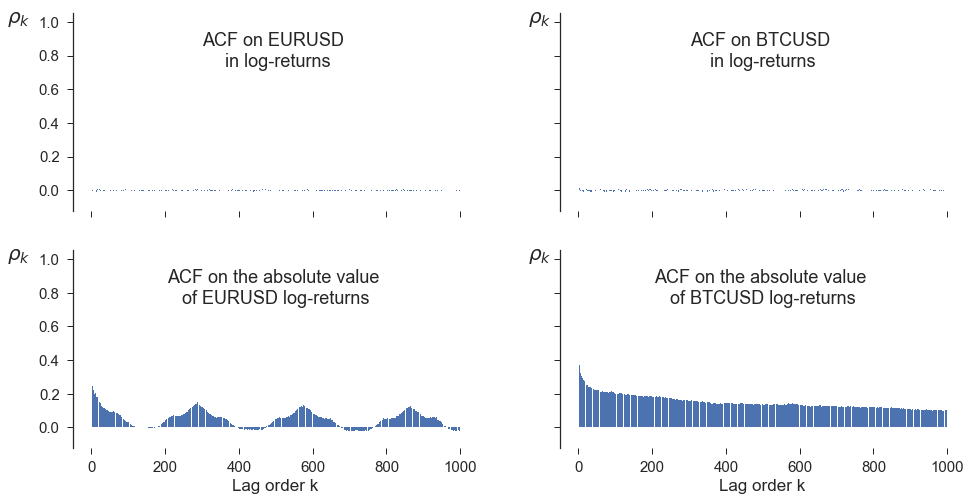

In [72]:
""" Analysis of ACF for log-returns and absolute value for EURUSD and BTCUSD:

"""
no_week_end = df_eurusd[df_eurusd.weekday.astype(str) != 'Saturday'].reset_index(drop=True)
no_week_end = no_week_end[no_week_end.weekday.astype(str) != 'Sunday'].reset_index(drop=True)

ET = EconometricTools()
gama_k_eurusd = ET.auto_cov_emp_vect(no_week_end.lr, 1000) / np.var(no_week_end.lr)
gama_k_btcusd = ET.auto_cov_emp_vect(df_btcusd.lr, 1000) / np.var(df_btcusd.lr)

gama_k_abs_eurusd = ET.auto_cov_emp_vect(no_week_end.abs_lr, 1000) / np.var(no_week_end.abs_lr)
gama_k_abs_btcusd = ET.auto_cov_emp_vect(df_btcusd.abs_lr, 1000) / np.var(df_btcusd.abs_lr)
grid = np.arange(1000)

sns.set(style="white", context="notebook", font_scale=1.5)
sns.set_style("ticks")

f, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.bar(grid, gama_k_eurusd, width=0.9)
ax1.set_title('ACF on EURUSD \n in log-returns', position=(0.5, 0.7))
ax1.yaxis.set_ticks(np.arange(0, 1.2, 0.2))
ax1.set_ylabel(r"$\rho_k$", labelpad=20, fontsize=20, rotation=0, x=0.07 ,y=0.92)

ax2.bar(grid, gama_k_abs_eurusd, width=0.9)
ax2.set_title('ACF on the absolute value \nof EURUSD log-returns', position=(0.5, 0.7))
ax2.yaxis.set_ticks(np.arange(0, 1.2, 0.2))
ax2.set_xlabel('Lag order k', fontsize=17)
ax2.set_ylabel(r"$\rho_k$", labelpad=20, fontsize=20, rotation=0, x=0.07, y=0.92)

ax3.bar(grid, gama_k_btcusd, width=0.9)
ax3.set_title('ACF on BTCUSD \nin log-returns', position=(0.5, 0.7))
ax3.set_ylabel(r"$\rho_k$", labelpad = 20, fontsize=20, rotation=0, x=0.12, y=0.92)
ax3.yaxis.set_ticks(np.arange(0, 1.2, 0.2))

ax4.bar(grid, gama_k_abs_btcusd, width=0.9)
ax4.set_title('ACF on the absolute value \nof BTCUSD log-returns', position=(0.5, 0.7))
ax4.yaxis.set_ticks(np.arange(0, 1.2, 0.2))
ax4.set_ylabel(r"$\rho_k$", labelpad=20, fontsize=20, rotation=0, x=0.12, y=0.92)
ax4.set_xlabel('Lag order k', fontsize=17)

sns.despine(bottom=True)
plt.show()

In [73]:
""" Analysis of the distribution for EURUSD and BTCUSD

"""
ET = EconometricTools()
sig_eurusd = np.std(df_eurusd.lr)
grid_eurusd = np.linspace(-5 * sig_eurusd, 5 * sig_eurusd, 200)
sig_abs_eurusd = np.std(df_eurusd.abs_lr)
grid_abs_eurusd = np.linspace(0, 5 * sig_abs_eurusd, 200)

PR_est_eurusd = ET.parzen_rosenblatt_estimator(grid_eurusd, df_eurusd.lr)
PR_est_abs_eurusd = ET.parzen_rosenblatt_estimator(grid_abs_eurusd, df_eurusd.abs_lr)

sig_btcusd = np.std(df_btcusd.lr)
grid_btcusd = np.linspace(-5 * sig_btcusd, 5 * sig_btcusd, 200)
sig_abs_btcusd = np.std(df_btcusd.abs_lr)
grid_abs_btcusd = np.linspace(0, 5 * sig_abs_btcusd, 200)

PR_est_btcusd = ET.parzen_rosenblatt_estimator(grid_btcusd, df_btcusd.lr)
PR_est_abs_btcusd = ET.parzen_rosenblatt_estimator(grid_abs_btcusd, df_btcusd.abs_lr)

***

In the next chart (see below the figure) we have plotted the distributions of the both series in terms of log-returns and absolute log-returns. These plots show us that the observations for both series are rather centered on the mean. However we have fat tails and a high distribution in the extreme values.

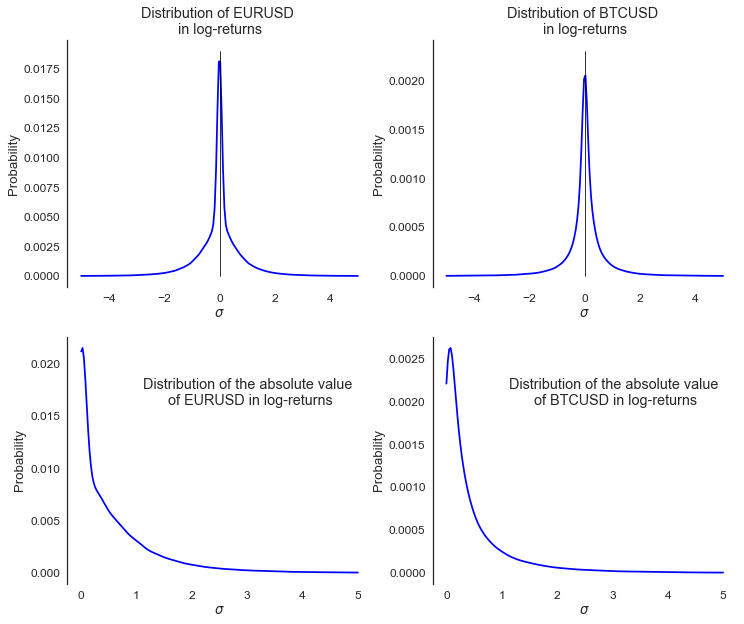

In [74]:
#
#  Plot
#
N_eurusd = len(df_eurusd.lr)
N_btcusd = len(df_btcusd.lr)
grid = range(100)
sns.set(style="white", context="notebook", font_scale=1.2)

f, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

ax1.plot(grid_eurusd/np.std(df_eurusd.lr), PR_est_eurusd / N_eurusd, 'b-')#, width = 0.9)
ax1.plot(np.array([0, 0]), np.array([0, 0.019]), 'k-', linewidth=0.8)
ax1.set_title('Distribution of EURUSD \nin log-returns')
ax1.set_ylabel('Probability')
ax1.set_xlabel(r"$\sigma$")

ax2.plot(grid_abs_eurusd/np.std(df_eurusd.abs_lr), PR_est_abs_eurusd / N_eurusd, 'b-')
ax2.set_title('Distribution of the absolute value \nof EURUSD in log-returns', 
              position=(0.6, 0.7))
ax2.set_ylabel('Probability')
ax2.set_xlabel(r"$\sigma$")

ax3.plot(grid_btcusd/np.std(df_btcusd.lr), PR_est_btcusd / N_btcusd, 'b-')
ax3.plot(np.array([0, 0]), np.array([0, 0.0023]), 'k-', linewidth=0.8)
ax3.set_title('Distribution of BTCUSD \nin log-returns')
ax3.set_ylabel('Probability')
ax3.set_xlabel(r"$\sigma$")

ax4.plot(grid_abs_btcusd/np.std(df_btcusd.abs_lr), PR_est_abs_btcusd / N_btcusd, 'b-')
ax4.set_title('Distribution of the absolute value \nof BTCUSD in log-returns', 
              position = (0.6, 0.7))
ax4.set_ylabel('Probability')
ax4.set_xlabel(r"$\sigma$")

sns.despine(bottom=True)
plt.show()

***
***

## II. Volatility periodicity analysis:

The study of the periodicity volatility is very useful for several reasons; one of them is the detection of jumps. First we compare the weekly periodic volatility of EUR-USD and BTC-USD absolute value of log-return. In this aim, we aggregated the 3 years data over one week such that we obtained the average for each five-minute over the week.

We see clearly that volatility of EUR-USD is periodic, with an increasing before the weekend. On the BTC-USD, the graph is less distinctive than the EUR-USD but we can always observe a periodicity, in particular an increasing before the weekend and a decreasing during the weekend. We quote a remark concerning the EUR-USD rate, this exchange rate is traded on the Foreign Exchange Market and it can be traded during the weekend but the activity is so low that its volatility is considered zero.

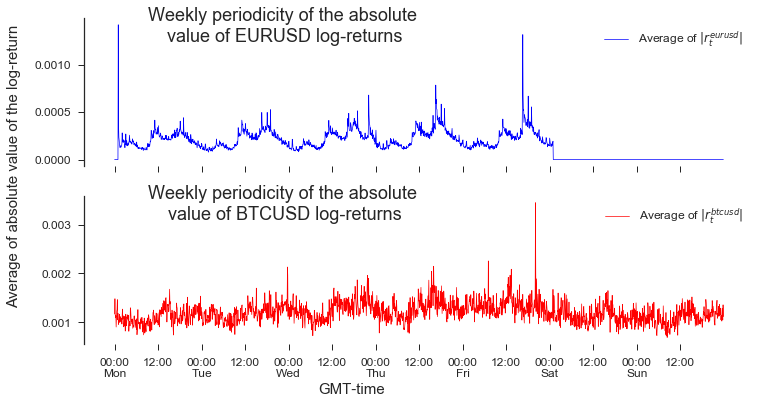

In [109]:
""" Analysis of the intraday periodicity for EURUSD and BTCUSD over one week.

"""
sns.set(style="white", context="notebook", font_scale=1.2)
sns.set_style("ticks")

cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
order = []
# Here we define a special grid to ordered the week day on the graph. Must be not the best way to do it. 
for elt in [list(range(288 * (e - 1), 288 * e)) for e in [5, 1, 6, 7, 4, 2, 3]]:
    order += elt

mean_eurusd = pd.DataFrame(
    df_eurusd, 
    columns=['weekday', 'day', 'time', 'abs_lr', 'lr']
).groupby(['weekday', 'time'])[
    'weekday', 
    'time', 
    'abs_lr', 
    'lr'
].mean().reset_index()

mean_eurusd['new_index'] = order
mean_eurusd = mean_eurusd.sort_values('new_index').reset_index().drop([
        'index', 
        'new_index'
    ], axis=1)

mean_btcusd = pd.DataFrame(
    df_btcusd, 
    columns=['weekday', 'day', 'time', 'abs_lr', 'lr']
).groupby(['weekday', 'time'])[
    'weekday', 
    'time', 
    'abs_lr', 
    'lr'
].mean().reset_index()

mean_btcusd['new_index'] = order
mean_btcusd = mean_btcusd.sort_values('new_index').reset_index().drop([
        'index', 
        'new_index'
    ], axis=1)

N = len(mean_eurusd.abs_lr)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(mean_eurusd.index, mean_eurusd.abs_lr, 'b-', linewidth=0.7)
ax1.set_title('Weekly periodicity of the absolute \nvalue of EURUSD log-returns', 
              fontsize=18, position = (0.3, 0.8))
ax1.legend([r'Average of $|r_t^{eurusd}|$'], fontsize=12, loc=1)

ax2.plot(mean_btcusd.index, mean_btcusd.abs_lr, 'r-', linewidth=0.7)
ax2.set_ylabel('Average of absolute value of the log-return', 
               labelpad=20, fontsize=15, x=0.07 ,y=1.2)
ax2.set_xlabel('GMT-time', fontsize=15, x=0.4)
ax2.set_title('Weekly periodicity of the absolute \nvalue of BTCUSD log-returns', 
              fontsize=18, position=(0.3, 0.8))
ax2.legend([r'Average of $|r_t^{btcusd}|$'], fontsize=12, loc=1)

plt.xticks([0, N / 14, N / 7, 3 * N / 14, N * 2 / 7, 5 *N / 14, N * 3 / 7, 7 * N / 14, 
            N * 4 / 7, 9 * N / 14, N * 5 / 7, 11 * N / 14, N * 6 / 7, 13 * N / 14], 
           ['00:00\nMon', '12:00', '00:00\nTue', '12:00', '00:00\nWed', 
            '12:00', '00:00\nThu', '12:00', '00:00\nFri', '12:00', 
            '00:00\nSat', '12:00', '00:00\nSun', '12:00'], rotation=0)
sns.despine(bottom=True)
plt.show()

***

Furthermore, we observe an intraday periodicity, to put in light this periodicity, as we did for weekly periodicity we aggregated the over only one day (see below the figure).

This chart is very interesting in that sense that we can observe the trading activity during a day. We can extract some information from it, if we decompose the time we are able to distinguish when and where we have the trading activity. And therefore who are behind this activity.

We start at 00:00 GMT, at this time two main markets are opened the Australian market which has already been trading for around three hours and the Japanese market that is currently opening up. This period of high market activity is present on the EUR-USD and BTC-USD markets and remains high until around 03:00 GMT. We observe another high volatility period associated to the BTC-USD when the Australian market closed at 07:00 GMT and just before the opening of the European market. From around 08:00 GMT the volatility increases due to European market opens and contributes with the Japanese market to the activity. From 13:00 to 18:00 GMT, the chart shows us the stronger volatility period over the day.
This high activity is linked to the US and European markets. After this period the activity decreases until the pacific market begins to trade again.

As a result, the level of volatility of these assets depends of course of when markets and traders are trading around the world.

From this last chart, we can affirm that the trading periodicity in a day concerning the EUR-USD rate is more detectable than the BTC-USD rate. Indeed the last rate has a volatility level relatively stable during the day. Consequently, the BTC-USD trading period over the day is relatively stable unlike the classic exchange rate that we can distinguish easily the periods of high and low trading periods.

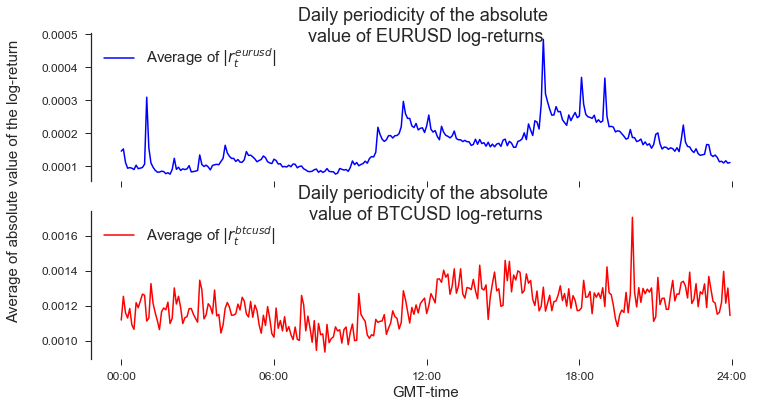

In [76]:
""" Analysis of the intraday periodicity for EURUSD and BTCUSD over one day.

"""
mean_eurusd = mean_eurusd.groupby(['time'])['time', 'abs_lr', 'lr'].mean().reset_index()
mean_btcusd = mean_btcusd.groupby(['time'])['time', 'abs_lr', 'lr'].mean().reset_index()
N = len(mean_eurusd.abs_lr)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(mean_eurusd.index, mean_eurusd.abs_lr, 'b-', linewidth=1.5)
ax1.set_title('Daily periodicity of the absolute \nvalue of EURUSD log-returns', 
              fontsize=18, position=(0.5, 0.9))
ax1.legend([r'Average of $|r_t^{eurusd}|$'], fontsize=15, loc=2)

ax2.plot(mean_btcusd.index, mean_btcusd.abs_lr, 'r-', linewidth=1.5)
ax2.set_ylabel('Average of absolute value of the log-return', 
               labelpad=20, fontsize=15, x=0.07 ,y=1.2)
ax2.set_xlabel('GMT-time', fontsize=15, x=0.5)
ax2.set_title('Daily periodicity of the absolute \nvalue of BTCUSD log-returns', 
              fontsize=18, position=(0.5, 0.9))
ax2.legend([r'Average of $|r_t^{btcusd}|$'], fontsize=15, loc=2)

plt.xticks([0, N / 4, N / 2, 3 * N / 4, N], ['00:00', '06:00', '12:00', '18:00', '24:00'])
sns.despine(bottom=True)
plt.show()

***
***

## III. Asymmetric effects on volatility

In order to study the asymmetric effect of shocks we regress the daily returns on the logarithm of the realized volatility, such that:

> $𝑙𝑛 𝑅𝑉_𝑡$ = $𝑐_0$ + $𝑐_1$$𝑦_𝑡$$_−$$_1$ + $𝑐_2$$𝑦_𝑡$$_−$$_1$$^−$ + $𝑢_𝑡$

With $y_t$ the daily returns, $𝑦_𝑡^−$ equal to 0 when $y_t$ > 0 and equal to $y_t$ otherwise. And $RV_t$ the daily realized volatility is computed by summing high frequency of the squared returns (here we consider five minutes interval is enough).

The first two charts above (see figures below) compare the different type of volatility, and the third displays the fitted values of these LS regressions for the EUR-USD exchange rate bases on 5-minutes. This graph suggests that anegative shock on the returns is more likely to be associated with a high volatility (the next day) than for a positive shock.

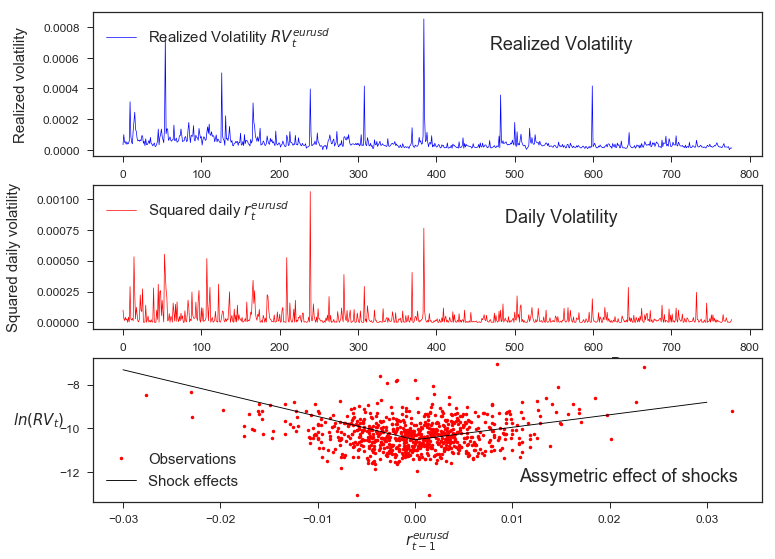

In [104]:
""" Realized variance for EURUSD.

"""
truc = df_eurusd[df_eurusd.weekday.astype(str) != 'Saturday'].reset_index(drop=True)
truc = truc[truc.weekday.astype(str) != 'Sunday'].reset_index(drop=True)

RV = np.sum(np.square(truc.pivot(index='day', columns='time', values='ret')), axis=1)[1: -1]
RV = pd.DataFrame(RV).reset_index().rename(columns={0: 'RV'})
end = truc[(truc.TS + 300) % (86400) == 0].drop([34, 149794], axis=0).reset_index(drop=True)#.drop(520, axis = 0)
daily_eurusd = truc[truc.TS % (86400) == 0].reset_index(drop=True)#.drop(313283, axis = 0)

daily_eurusd = daily_eurusd.assign(sdr = (np.array(end.close) - np.array(daily_eurusd.close)) ** 2, 
                                   daily_ret = np.array(end.close) - np.array(daily_eurusd.close), 
                                   neg_daily_ret = np.array(end.close) - np.array(daily_eurusd.close))
daily_eurusd = pd.merge(daily_eurusd, RV, how='inner', on='day')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1.plot(daily_eurusd.RV, 'b-', linewidth=0.7)
ax1.set_ylabel('Realized volatility', labelpad=15, fontsize=15, x=0.07 ,y=0.5)
ax1.set_title('Realized Volatility', fontsize=18, position=(0.7, 0.7))
ax1.legend([r'Realized Volatility $RV_t^{eurusd}$'], fontsize=15, loc=2)

ax2.plot(daily_eurusd.sdr, 'r-', linewidth=0.7)
ax2.set_ylabel('Squared daily volatility', labelpad=15, fontsize=15, x=0.07 ,y=0.5)
ax2.set_xlabel('Days', fontsize=15, x=0.8)
ax2.set_title('Daily Volatility', fontsize=18, position=(0.7, 0.7))
ax2.legend([r'Squared daily $r_t^{eurusd}$'], fontsize=15, loc=2)

to_del = [i for i in daily_eurusd.index if float(daily_eurusd.RV[i]) == 0]
daily_eurusd = daily_eurusd.drop(to_del, axis=0)

def f_neg(x):
    if x >= 0:
        return 0
    else:
        return x
    
daily_eurusd.neg_daily_ret = daily_eurusd.neg_daily_ret.apply(f_neg)
N = len(daily_eurusd.index)
one = np.ones(N - 1)
M = np.reshape(
    np.concatenate(
        (
            np.transpose(one), 
            np.transpose(daily_eurusd.daily_ret[: -1]), 
            np.transpose(daily_eurusd.neg_daily_ret[: -1])
        )
    ), 
    (3, N - 1)
)
ET = EconometricTools()
[c, b1, b2] = ET.ols_est(np.transpose(M), np.array(np.log(daily_eurusd.RV[1: ])))

ax3.plot(daily_eurusd.daily_ret[: -1], np.log(daily_eurusd.RV[1: ]), 'r.', linewidth='0.5')
ax3.plot(np.array([0, 0.03]), np.array([0, 0.03]) * b1 + c, 'k-', linewidth='0.9')
ax3.plot(np.array([-0.03, 0]), np.array([-0.03, 0]) * b2 + c, 'k-', linewidth='0.9')
ax3.set_ylabel(r'$ln(RV_t)$', labelpad=21, fontsize=15, x=0.07 ,y=0.5, rotation=0)
ax3.set_xlabel(r'$r_{t-1}^{eurusd}$', fontsize=15, x=0.5)
ax3.set_title('Assymetric effect of shocks', fontsize=18, position=(0.8, 0.1))
ax3.legend(['Observations', 'Shock effects'], fontsize=15, loc=3)

plt.show()

***
*A remark on this chart, for the volatility of the bitcoin we had to put a logarithmic scale on the graph because returns increase exponentially, it is probably an explosive process.*

The third chart (see figure below) displays the fitted values of these LS regressions for the BTC-USD exchange rate bases on 5-minutes. This graph suggests again that a negative shock on the returns is more likely to be associated with a high volatility (the next day) than for a positive shock.

[5.320859147217964, 0.007535557959988939, -0.01715692701281981]


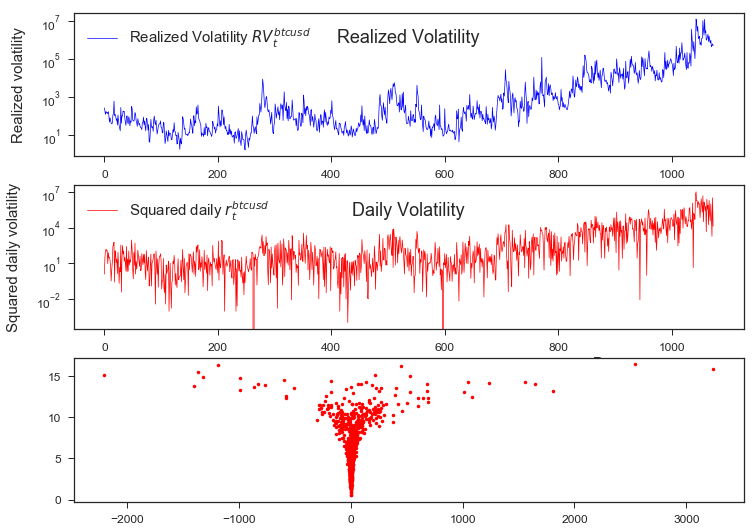

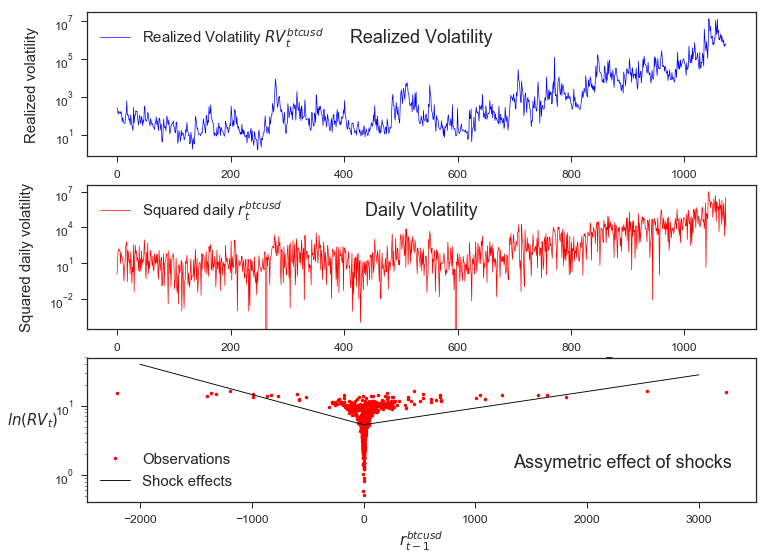

In [107]:
""" Realized variance for BTCUSD.

"""
RV = np.sum(np.square(df_btcusd.pivot(index='day', columns='time', values='ret')), axis=1)[1: -1]
RV = pd.DataFrame(RV).reset_index().rename(columns={0: 'RV'})
end = df_btcusd[(df_btcusd.TS + 300) % (86400) == 0].drop(264, axis=0).reset_index(drop=True)
daily_btcusd = df_btcusd[df_btcusd.TS % (86400) == 0].drop(309577, axis=0).reset_index(drop=True)

daily_btcusd = daily_btcusd.assign(sdr = (np.array(end.close) - np.array(daily_btcusd.close)) ** 2, 
                                   daily_ret = np.array(end.close) - np.array(daily_btcusd.close), 
                                   neg_daily_ret = np.array(end.close) - np.array(daily_btcusd.close))
daily_btcusd = pd.merge(daily_btcusd, RV, how='inner', on='day')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

ax1.plot(daily_btcusd.RV, 'b-', linewidth=0.7)
ax1.set_ylabel('Realized volatility', labelpad=15, fontsize=15, x=0.07 ,y=0.5)
ax1.set_title('Realized Volatility', fontsize=18, position=(0.5, 0.75))
ax1.legend([r'Realized Volatility $RV_t^{btcusd}$'], fontsize=15, loc=2)
ax1.set_yscale('log')

ax2.plot(daily_btcusd.sdr, 'r-', linewidth=0.7)
ax2.set_ylabel('Squared daily volatility', labelpad=15, fontsize=15, x=0.07 ,y=0.5)
ax2.set_xlabel('Days', fontsize=15, x=0.8)
ax2.set_title('Daily Volatility', fontsize=18, position=(0.5, 0.75))
ax2.legend([r'Squared daily $r_t^{btcusd}$'], fontsize=15, loc=2)
ax2.set_yscale('log')

#to_del = [i for i in daily_eurusd.index if float(daily_eurusd.RV[i]) == 0]
#daily_eurusd = daily_eurusd.drop(to_del, axis = 0)

def f_neg(x):
    if x >= 0 :
        return 0
    else:
        return x
    
daily_btcusd.neg_daily_ret = daily_btcusd.neg_daily_ret.apply(f_neg)
N = len(daily_btcusd.index)
one = np.ones(N - 1)
M = np.reshape(np.concatenate((np.transpose(one), 
                               np.transpose(daily_btcusd.daily_ret[: -1]), 
                               np.transpose(daily_btcusd.neg_daily_ret[: -1]))), 
               (3, N - 1))
ET = EconometricTools()
[c, b1, b2] = ET.ols_est(np.transpose(M), np.array(np.log(daily_btcusd.RV[1: ])))
print([c, b1, b2])

ax3.plot(daily_btcusd.daily_ret[: -1], np.log(daily_btcusd.RV[1: ]), 'r.', linewidth='0.5')
ax3.plot(np.array([0, 3000]), np.array([0, 3000]) * b1 + c, 'k-', linewidth='0.9')
ax3.plot(np.array([-2000, 0]), np.array([-2000, 0]) * b2 + c, 'k-', linewidth='0.9')
ax3.set_ylabel(r'$ln(RV_t)$', labelpad=21, fontsize=15, x=0.07 ,y=0.5, rotation=0)
ax3.set_xlabel(r'$r_{t-1}^{btcusd}$', fontsize=15, x=0.5)
ax3.set_title('Assymetric effect of shocks', fontsize=18, position=(0.8, 0.2))
ax3.legend(['Observations', 'Shock effects'], fontsize=15, loc=3)
ax3.set_yscale('log')

plt.show()

***
***
## Conclusion:

The purpose of this study was to detect some similarities between the bitcoin and the euro-dollar exchange rate in terms of price behavior. Our results show us important information. One of them is the questioning of a fundamental property of the role of money that is the value reserve. Indeed the bitcoin is much more volatile than the euro-dollar exchange rate and its price is completely unstable. This extreme volatility concerning the bitcoin is a characteristic wanted by some speculators but its goal to being a real currency is far from being achieved. However, we remark that their periods of volatility are similar between both during the week and also the day. Furthermore we remark that the both assets admit a higher volatility after a negative shock rather than after a positive shock.